In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from time import process_time
from scipy.optimize import *
from scipy.optimize import minimize_scalar

# !pip install pyMCFSimplex
from pyMCFSimplex import *

#### 1. Generazione delle istanze del problema
La prima funzione *genera_Q(alpha, u, q, dimensione, p)* serve per generare i costi quadratici 
che si aggiungono ai costi lineari dell'istanza di MCF;
la stategia di generazione prevede di generare randomicamente (uniformemente) costi Qij "piccoli" o "grandi" rispetto ai costi lineari, 
come specificato dal parametro *alpha*. 

Permette inoltre di definire - tramite il parametro *p* - la proporzione di archi che hanno costo quadratico Qij nullo, 
abilitando la definizione e l'analisi anche di matrici semi-definite positive. 

La seconda funzione *leggi_file_dimacs(nome_file)* serve per estrarre le seguenti quantità: 
 - u, b, q
 - numero nodi
 - numero archi 

dal relativo file *.dmx*, generato [qui](https://commalab.di.unipi.it/datasets/mcf/). 

In [3]:
def genera_Q(alpha, u, q, dimensione, p):
    
    Q_diag = []

    for i in range(dimensione):
        Q_i = abs(random.uniform((-q[i] / u[i] * alpha), (q[i] / u[i] * alpha))) # generazione randomica 
        Q_diag.append(Q_i)

    Q = np.zeros((dimensione, dimensione))
    np.fill_diagonal(Q, Q_diag) # creazione matrice 

    num_entrate_zero = int(p * dimensione) 
    indici_zeri = np.random.choice(dimensione, num_entrate_zero, replace=False) # trova p*dimensione indici dei costi quadratici da mettere a zero 

    for idx in indici_zeri:
        Q[idx, idx] = 0
        # Q_diag[idx] = 0

    return Q #, Q_diag


def leggi_file_dimacs(nome_file):
    numero_nodi = 0
    numero_archi = 0
    u = []
    b = []
    q = []
    from_= []
    to_= []
    edges = []

    with open(nome_file, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 0:
                if parts[0] == 'p':  # parts[0] è il primo carattere di ogni riga - nel formato standard DIMACS può essere c, p, n, a
                    # legge il numero di nodi e archi dal problema
                    numero_nodi = int(parts[2])
                    numero_archi = int(parts[3])
                    # inizializza il vettore di supply con zeri
                    b = [0] * numero_nodi
                elif parts[0] == 'n':
                    # legge i valori di supply per i nodi
                    nodo_id = int(parts[1])
                    supply = int(parts[2])
                    # assegna il valore di supply al nodo corrispondente
                    b[nodo_id - 1] = supply
                elif parts[0] == 'a':
                    # leggi l'arco e il suo cotso
                    from_node = int(parts[1])
                    to_node = int(parts[2])
                    max_capacity = int(parts[4])
                    costo = int(parts[5])  # leggiamo costo corretto
                    from_.append(from_node)
                    to_.append(to_node)
                    u.append(max_capacity)
                    q.append(costo)
                    edges.append((from_node , to_node ))

    return numero_nodi, numero_archi, np.array(u), b, np.array(q), edges,from_, to_

#### 2. Algoritmo FW TRADIZIONALE

Step: 

0. Inizializzazione di x<sub>0</sub> con generazione casuale soggetta al vincolo 0 &le; x<sub>0</sub> &le; u
1. Calcolo del gradiente, risoluzione del sottoproblema lineare usando il solver pyMCFSimplex (x̄), determinazione della direzione
2. Determinazione dello step size &alpha;
3. Aggiornamento della posizione e check terminazione sul prodotto scalare (<grad, d>)

In [4]:
# Questa funzione crea un nuovo file .dmx in cui i valori delle righe che iniziano con 'a' (definizione archi)
# vengono sostituiti con i valori presenti nel vettore gradient. L'obiettivo è modificare il file di input 
# (input_file) in modo da utilizzare al posto dei costi lineari del file originale, il gradiente 
# (vogliamo risolvere il sottoproblema lineare, aka l'approssimazione lineare del problema Taylor 1st ordine).   

def modify_file_with_gradient(input_file, output_file, gradient):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # inizalizzazione dell'indice per il vettore gradient
    gradient_index = 0

    # modifica delle righe che iniziano con 'a'
    for i in range(len(lines)):
        if lines[i].startswith('a'):
            words = lines[i].split()
            words[-1] = str(gradient[gradient_index])
            gradient_index += 1
            lines[i] = ' '.join(words)

    # creazione nuovo file
    with open(output_file, 'w') as file:
        file.writelines(lines)

In [5]:
# questo codice serve per calcolare lo step size trovando alpha che minimizzi f (xk + α(dk − xk))
# rispettando il vincolo 0 ≤ α ≤ 1. dove f è la nostra funzione di costo. 

# definizione della funzione quadratica - la nostra f iniziale x^TQx + q
def quadratic_function(alpha, xk, dk, Q, q):

    x_alpha = [x + alpha * (d - x) for x, d in zip(xk, dk)] 
    x_alpha = np.array(x_alpha) 

    # calcolo il valore della funzione obiettivo
    return x_alpha.T @ Q @ x_alpha + q @ x_alpha


def find_optimal_alpha(xk, dk, Q, q): # exact line search
   
    objective_function = lambda alpha: quadratic_function(alpha, xk, dk, Q, q) # nostra funzione obiettivo che dipende da alpha 
    result = minimize_scalar(objective_function, bounds=(0, 1), method = 'bounded') # soluzione del problema di minimo con vincolo su alpha che deve stare tra 0 e 1 

    return result.x


In [6]:

def showModuleFunctionality(mcf):
    vettore_soluzione = {}  
    nmx = mcf.MCFnmax()
    mmx = mcf.MCFmmax()
    pn = mcf.MCFnmax()
    pm = mcf.MCFmmax()

    pU = []
    caps = new_darray(mmx)
    mcf.MCFUCaps(caps)
    for i in range(0, mmx):
        pU.append(darray_get(caps, i))

    pC = []
    costs = new_darray(mmx)
    mcf.MCFCosts(costs)
    for i in range(0, mmx):
        pC.append(darray_get(costs, i))

    pDfct = []
    supply = new_darray(nmx)
    mcf.MCFDfcts(supply)
    for i in range(0, nmx):
        pDfct.append(darray_get(supply, i))

    pSn = []
    pEn = []
    startNodes = new_uiarray(mmx)
    endNodes = new_uiarray(mmx)
    mcf.MCFArcs(startNodes, endNodes)
    for i in range(0, mmx):
        pSn.append(uiarray_get(startNodes, i) + 1)
        pEn.append(uiarray_get(endNodes, i) + 1)

    #print("arc flow")
    length = mcf.MCFm()
    flow = new_darray(length)
    length = mcf.MCFn()
    nms = new_uiarray(length)
    mcf.MCFGetX(flow, nms)

   

    for i in range(0, length):
       # print("flow", darray_get(flow, i), "arc", uiarray_get(nms, i))
        vettore_soluzione[uiarray_get(nms, i)] = darray_get(flow, i)

    return vettore_soluzione  # restituisce il vettore_soluzione alla fine della funzione

In [33]:
def visualize(k, soluzione_ottima, alpha, prodotto_scalare, k_granularity, tempo, end, found_optimal): 

    # la funzione stampa un summary delle seguenti quantità ad ogni iterazione (oppure ogni 'k_granularity' iterazioni) :
    # - iterazione corrente
    # - step size, 
    # - optimal solution, 
    # - prodotto scalare 

    # alla fine dell'esecuzione verrà mostrato :
    # - prodotto scalare finale,
    # - step size finale
    # - numero totale di iterazioni
    # - tempo di esecuzione totale 
    
    if end:
        print("_"*110)
        print("STOP: ")
        if found_optimal:
            print('Found optimal solution!')
        print('Final scalar product: {:>10.2f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(prodotto_scalare, alpha, k))
        print('Total running time: {:>10.2f} seconds'.format(tempo))    
        
    if  k % k_granularity == 0:
        print('Iteration: {:>4}   Step size: {:>10.8f}   Optimal solution: {:>10.6f}   Scalar product grad, d: {:>10.2f} '.format(k, alpha, soluzione_ottima, prodotto_scalare))
    return

In [16]:
def algoritmo_tradizionale(nome_file, epsilon, max_iter, Q, q, u, numero_archi, tau, step_size_ottimo=True):
    
    k = 0 
    alpha = 1 
    prodotto_scalare = float("inf")
    start_time = time.time()
    tempo_tot = 0
    end = False
    found_optimal = False
    gap = []
    tempi_per_it = [0]
    f_values = []
    


    # STEP 0 : inizializzazione di x_0
    seed = 42
    np.random.seed(seed)
    x_old = []

    for u_i in u:
        x_i = random.randint(0, u_i)
        x_old.append(x_i)
    

    while  (abs(prodotto_scalare)>= epsilon and k < max_iter):

        start_it = process_time()

        f_x_current = np.dot(np.dot(x_old, Q), x_old) + np.dot(q, x_old)
        f_values.append(f_x_current)

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x_old)) + q
        gradient = gradient.tolist()
        modify_file_with_gradient(nome_file, 'output.dmx', gradient)

        # risoluzione del problema lineare (ricerca di argmin) con MCF solver
        FILENAME = 'output.dmx'
        f = open(FILENAME,'r')
        inputStr = f.read()
        f.close()
        mcf = MCFSimplex()
        mcf.LoadDMX(inputStr)
        mcf.SolveMCF()
        if mcf.MCFGetStatus() == 0:
            soluzione_ottima = mcf.MCFGetFO()
            visualize(k, soluzione_ottima , alpha, prodotto_scalare, k_granularity = 5, tempo = tempo_tot, end = end, found_optimal = found_optimal)

        else:
            print( "Problem unfeasible!")
         
        vettore_soluzione = showModuleFunctionality(mcf)
     
        sol_x = [0] * numero_archi
        for key in vettore_soluzione:
            if key <= 1000:
                sol_x[key-1] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        x_bar = np.array(sol_x.copy())

        # TRUST REGION STABILIZATION
        u = np.array(u)
        if tau > 0: 
            lb = x_bar - tau * u # calcolo lower bound e upper bound della trust region 
            ub = x_bar + tau * u
            x_bar = np.maximum(lb, np.minimum(x_bar, ub)) 

        d = [a - b for a, b in zip(x_bar, x_old)] # direzione


        # STEP 2 : determinazione alpha, step size 

        if step_size_ottimo:
            alpha = find_optimal_alpha(x_bar, d, Q, q)
        else:
            alpha = 2 / (2+k)

        # STEP 3 : aggiornamento della posizione
        x_new = []

        for i in range(len(x_old)):
            x_i_new = x_old[i] + alpha * d[i]
            x_new.append(x_i_new)

        # check terminazione 
        gradient_per_check = (2 * np.dot(Q, x_new) ) + q
        prodotto_scalare = np.dot(gradient_per_check, d)

        gap.append(prodotto_scalare)

        # aggiornamento poszione e incremento numero di iterazioni
        x_old = x_new
        k += 1

        end_it = process_time()
        tempi_per_it.append(tempi_per_it[k-1] + end_it - start_it)

        if not(abs(prodotto_scalare)>= epsilon and k < max_iter):
            end = True
            if k < max_iter:
                found_optimal = True
            end_time = time.time()
            tempo_tot = end_time - start_time
            visualize(k, soluzione_ottima, alpha, prodotto_scalare, k_granularity = 5, tempo = tempo_tot, end = end, found_optimal = found_optimal)
    
    
    return gap, f_values, k, tempo_tot, tempi_per_it, x_old, soluzione_ottima, found_optimal

In [35]:
#def pipeline(nome_file_dmx): # pipeline per algoritmo tradizionale

    #f_values = []
    
    # _, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    # Q = genera_Q(10, u, q, numero_archi, 0)
    # valori_f, k_totale = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.1, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, f_values = f_values, tau = 0.01, step_size_ottimo = True)

    # return valori_f, k_totale

# prova pipeline algo tradizionale
# valori_f, k_totale = pipeline(nome_file_dmx = '1000/netgen-1000-1-1-a-b-ns.dmx')

In [26]:
## PROVA

nome_file_dmx = '1000/netgen-1000-1-1-a-b-ns.dmx'
_, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
Q = genera_Q(100, u, q, numero_archi, 0.1)

gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.1, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, step_size_ottimo = True)

Iteration:    0   Step size: 1.00000000   Optimal solution: 102037.864952   Scalar product grad, d:        inf  Time per it:   0.000000


Iteration:    5   Step size: 0.06362083   Optimal solution: 84147.032591   Scalar product grad, d: -40532505.48  Time per it:   0.171875
Iteration:   10   Step size: 0.13806950   Optimal solution: 58008.253010   Scalar product grad, d: -15147672.61  Time per it:   0.234375
Iteration:   15   Step size: 0.56045424   Optimal solution: 19625.433108   Scalar product grad, d: -738178.43  Time per it:   0.296875
Iteration:   20   Step size: 0.99999404   Optimal solution: 8660.000000   Scalar product grad, d:   22415.83  Time per it:   0.421875
______________________________________________________________________________________________________________
STOP: 
Found optimal solution!
Final scalar product:       0.00  Final step size: 0.99999404  Total number iterations:   24
Total running time:       2.41 seconds


In [31]:
def plot_convergenza(f_values, k_tot, Q, nome_file_dmx):
    
    # questa funzione plotta un grafico di convergenza: 
    # viene mostrato l'andamento della convergenza teorica e reale

    # conv teorica  :  f(x)-f(x^*) <=  2LD^2 / (k+3)
    _, _, u, _, _, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q_diag = np.diag(Q)

    # l'autovalore massimo di Q è la costante di convergenza L 
    L = np.max(Q_diag)
    # il diametro dello spazio D è la norma del vettore u 
    D = np.linalg.norm(u) 

    k_values = []  # valori di k (iterazione)
    convergence_values = []  # valori di convergenza teorica

    # simulo i dati teorici (convergenza teorica)
    for k in range(1, k_tot + 1):
        k_values.append(k)
        convergence_values.append((2 * L * D**2) / (k + 3)) # formula converg teorica

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, convergence_values, label="Convergenza Teorica", linestyle='--', linewidth = 3)
    plt.plot(k_values, f_values, label="Convergenza Effettiva", linestyle='-', linewidth = 3)

    plt.xlabel("Iterazione (k)", fontsize = 12)
    plt.ylabel("Valore di Convergenza", fontsize = 12)
    plt.legend()
    plt.title("Convergenza teorica vs effettiva", fontsize = 15)
    plt.grid(True)

    plt.show()

    return

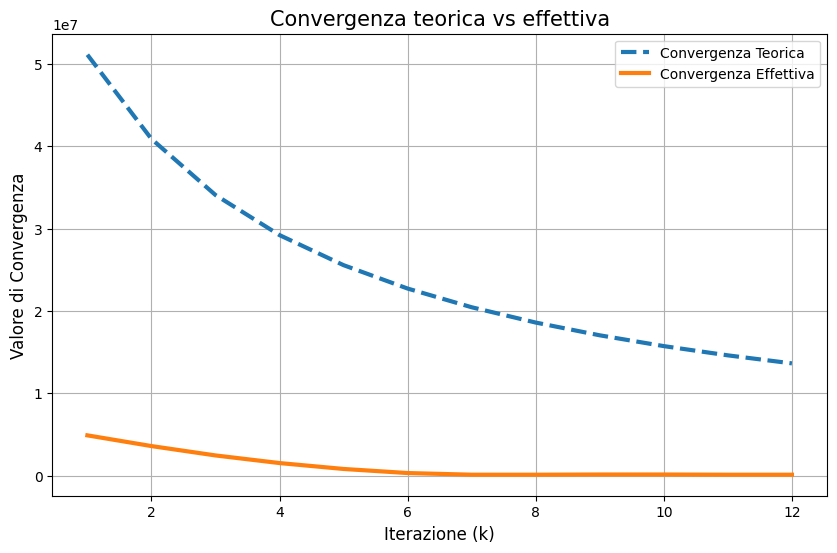

In [32]:
plot_convergenza(valori_f, k_totale, Q, nome_file_dmx)

### 3. Algoritmo FW variante - AWAY STEP

In [27]:
#Function to compute away vertex
def away_step(grad, S):
    
    '''
    Compute away vertex by searching over current active set
    '''
    
    costs = {}
    
    for k,v in S.items():
        cost = np.dot(k,grad)
        costs[cost] = [k,v]
    vertex, alpha = costs[max(costs.keys())]  
    return vertex,alpha

#Function to update active set
def update_S(S,gamma, Away, vertex):
    
    '''
    Update convex decompistion of active step after every iteration 
    '''
    
    S = S.copy()
    vertex = tuple(vertex)
    
    if not Away:
        if vertex not in S.keys():
            S[vertex] = gamma
        else:
            S[vertex] *= (1-gamma)
            S[vertex] += gamma
            
        for k in S.keys():
            if k != vertex:
                S[k] *= (1-gamma)
    else:
        for k in S.keys():
            if k != vertex:
                S[k] *= (1+gamma)
            else:
                S[k] *= (1+gamma)
                S[k] -= gamma
    return {k:v for k,v in S.items() if np.round(v,3) > 0}


In [28]:
def line_search(x, d, gamma_max,func):
    
    #line-search using Brent's rule in scipy
    
    '''
    Minimizes f over [x, y], i.e., f(x+gamma*d) as a function of scalar gamma in [0,gamma_max]
    '''

    def fun(gamma):
        ls = x + gamma*d
        return func(ls)

    res = minimize_scalar(fun, bounds=(0, gamma_max), method='bounded')

    gamma = res.x
    ls = x + gamma*d        
    return ls, gamma

In [70]:
#AFW Algorithm
   
def AFW(nome_file, epsilon, max_iter, Q, q, u, numero_archi,func, k_granularity):
    
    k = 0    
    gamma = 1
    start_time = time.time()
    tempo_tot = 0
    prodotto_scalare = float("inf")
    end = False
    found_optimal = False
    f_values = []
    tempi_per_it = [0]
    gap = []
    

    # STEP 0 : inizializzazione di x_0
    seed = 42
    np.random.seed(seed)
    x_old = []

    for u_i in u:
        x_i = random.randint(0, u_i)
        x_old.append(x_i)
    x_old=np.array(x_old)

  
    S = {tuple(x_old): 1} # active set inizializzazione

    while abs(prodotto_scalare)>= epsilon and k < max_iter: # stopping criteria

        start_it = process_time()

        f_x_current = np.dot(np.dot(x_old, Q), x_old) + np.dot(q, x_old)
        f_values.append(f_x_current)

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x_old)) + q
        modify_file_with_gradient(nome_file, 'output3.dmx', gradient)

        # risoluzione del problema lineare (ricerca di argmin) con MCF solver
        FILENAME = 'output3.dmx'
        f = open(FILENAME,'r')
        inputStr = f.read()
        f.close()
        mcf = MCFSimplex()
        mcf.LoadDMX(inputStr)
        mcf.SolveMCF()
        if mcf.MCFGetStatus() == 0:
            soluzione_ottima = mcf.MCFGetFO()
            visualize(k, soluzione_ottima , gamma, prodotto_scalare, k_granularity = k_granularity, tempo = tempo_tot, end = end, found_optimal = found_optimal)

        else:
            print( "Problem unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
     
        sol_x = [0] * numero_archi
        for key in vettore_soluzione:
            if key <= 1000:
                sol_x[key-1] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        v = sol_x.copy()
    
        d_FW = v - x_old
        
        # calcolo away vertex e direzione d_A 
        a, alpha_a = away_step(gradient, S)
        d_A = x_old - a

        # Check se FW gap è maggiore dell'away gap --> per capire quale passo usare 
        if np.dot(-gradient, d_FW) >= np.dot(-gradient, d_A):
            # scegliamo FW direction
            d = d_FW
            vertex = v
            gamma_max = 1
            Away = False
        else:
            # scegliamo Away direction
            d = d_A
            vertex = a
            # ATTENZIONE ZERO DIVISION ERROR QUI 
            gamma_max = alpha_a/(1-alpha_a)
            # print('alpha AFW:', alpha_a)
            Away = True

        # ricerca di x_new e gamma usando line search 
        prodotto_scalare = np.dot(gradient, d)
        x_new, gamma = line_search(x_old,d, gamma_max, func)

        # aggiornamento active set
        S = update_S(S,gamma, Away, vertex)


        gradient_per_check = (2 * np.dot(Q, x_new) ) + q
        prodotto_scalare = np.dot(gradient_per_check, d)

        gap.append(prodotto_scalare)


        x_old = x_new
        k+=1

        end_it = process_time()
        tempi_per_it.append(tempi_per_it[k-1] + end_it - start_it)

        if not(abs(prodotto_scalare)>= epsilon and k < max_iter):
            end = True
            if k < max_iter:
                found_optimal = True
            end_time = time.time()
            tempo_tot = end_time - start_time
            visualize(k, soluzione_ottima , gamma, prodotto_scalare, k_granularity= k_granularity, tempo = tempo_tot, end = end, found_optimal = found_optimal)
    

    return gap, f_values, k, tempo_tot, tempi_per_it, x_old, found_optimal


In [106]:
#def pipeline_AFW(nome_file_dmx): #questa è la pipeline per AFW

 #   f_values = []
  #  func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)

   # _, numero_archi, u, _, q, _,_, _ = leggi_file_dimacs(nome_file_dmx)
    #Q = genera_Q(10, u, q, numero_archi, 0)

    #AFW(nome_file_dmx, epsilon = 0.1, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi,f_values=f_values,func=func, k_granularity=10) # k granularity è ogni quante iterazioni voglio stampare l'output 
    
    #return 

#pipeline_AFW(nome_file_dmx = '1000/netgen-1000-1-1-b-a-ns.dmx')


In [79]:
nome_file_dmx = '1000/netgen-1000-1-2-a-a-s.dmx'

func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)
_, numero_archi, u, _, q, _,_, _ = leggi_file_dimacs(nome_file_dmx)
Q = genera_Q(1000, u, q, numero_archi, 0.2)

gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_old_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.001, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, func=func, k_granularity=10)


Iteration:    0   Step size: 1.00000000   Optimal solution: 585026.992920   Scalar product grad, d:        inf 
______________________________________________________________________________________________________________
STOP: 
Found optimal solution!
Final scalar product:      -0.00  Final step size: 0.99279594  Total number iterations:    1
Total running time:       0.05 seconds


### 4. Funzioni per PLOT

#### idea per grafico
1. con gap = f(x)-f(x*) in funzione di k 
2. con gap in funzione del tempo totale <br>
nb: a parità di x_0 iniziali, di problema, di tutti gli altri parametri <br> <br>
primal gap := f(x)-f(x*) <br>
dual gap aka FW gap := max <grad f(x), x-v> <br>

quest'ultimo può essere usato quando, non conoscendo x*, non si può calcolare esplicitamente il primal gap <br>
(a parte il caso base in cui abbiamo una formulazione esplicita che non dipende da x*). <br>
il dual gap è un upper bound del primal gap

In [58]:
# queste due funzioni plottano il FW (dual) gap e il primal gap 
def plot_dual_gap(gap_fw, gap_afw):
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    plt.plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW tradizionale')
    plt.plot(iterazioni_afw, gap_afw, color = '', label = 'FW Away Step')

    plt.xlabel('Iterazioni (k)')
    # plt.yscale('log')
    plt.ylabel('dual gap = |<grad(f), d>|', fontdict={'style': 'italic'})
    
    plt.title('Andamento del Dual Gap (aka FW Gap) in funzione di k')
    plt.legend()
    plt.grid(True)

    plt.show()


def plot_primal_gap(f_values, xstar, found_optimal):   # f(x) - f(x*)

    # check iniziale:  
    # se l'algoritmo ha trovato x ottima (ie il criterio di stop verificato è quello sul gap, non su max iter)
    # allora ha senso calcolare f(x*)
    if found_optimal:
        xstar = np.array(xstar)
        fxstar = xstar.T @ Q @ xstar + q @ xstar
        gap = np.abs(f_values - fxstar)
        iterazioni = list(range(1, len(f_values) + 1))
        
        plt.style.use('ggplot')
        plt.figure(figsize=(8, 6))
        plt.plot(iterazioni, gap, color = 'lightseagreen', label = 'FW tradizionale')
        plt.xlabel('Iterazioni (k)')
        # plt.yscale('log')
        plt.ylabel('primal gap = |f(x) - f(x*)|', fontdict={'style': 'italic'})
        
        plt.title('Andamento del Primal Gap in funzione di k')
        plt.legend()
        plt.grid(True)

        plt.show()
        
    else: 
        ('primal gap non disponibile')


    

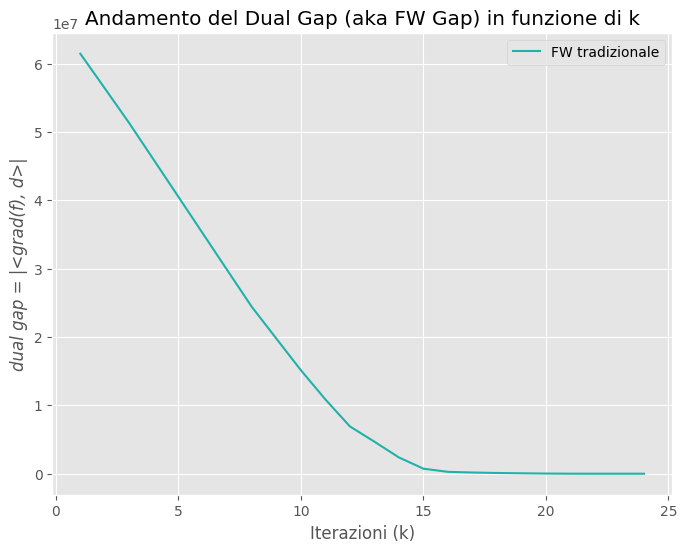

In [60]:
plot_dual_gap(gap)


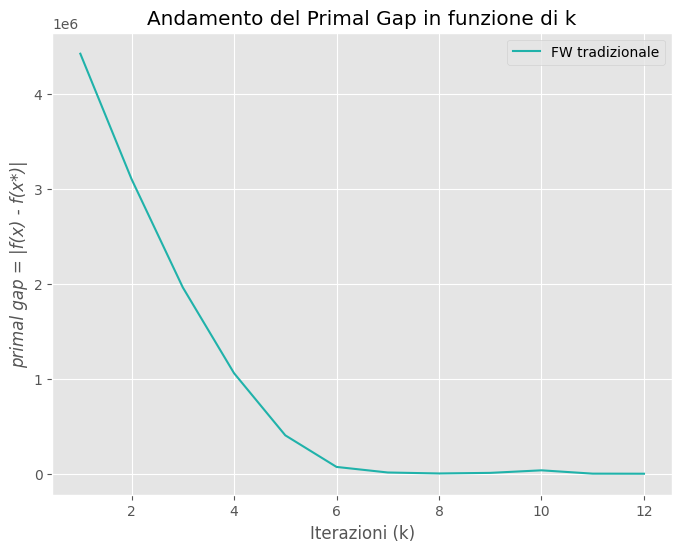

In [22]:
plot_primal_gap(valori_f, x, found_optimal)

In [82]:
# l'obiettivo di questa funzione è mostrare che effettivamente il FW gap (dual gap) costituisce un upper bound al primal gap

# si potrebbe anche eliminare 
def plot_dual_and_primal_gap(f_values, dual_gap, xstar):
    dual_gap = np.abs(dual_gap)
    iterazioni = list(range(1, len(dual_gap) + 1))
    
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    
    plt.plot(iterazioni, dual_gap, color='lightseagreen', label='Dual Gap (aka FW Gap)')
    
    xstar = np.array(xstar)
    fxstar = xstar.T @ Q @ xstar + q @ xstar
    primal_gap = np.abs(f_values - fxstar)
    plt.plot(iterazioni, primal_gap, color='dodgerblue', label='Primal Gap')
    
    plt.xlabel('Iterazioni (k)')
    plt.ylabel('Gap', fontdict={'style': 'italic'})
    
    plt.title('Andamento del Dual Gap e del Primal Gap in funzione di k')
    plt.legend()
    plt.grid(True)

    plt.show()


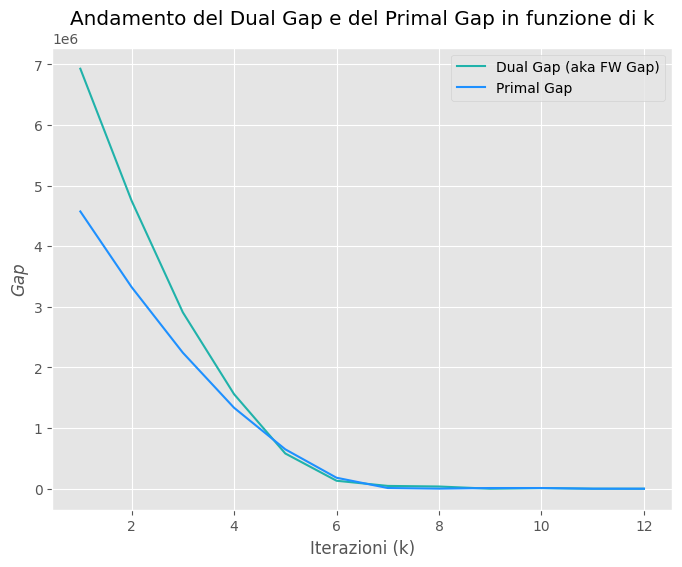

In [83]:
plot_dual_and_primal_gap(valori_f, gap, x)

### Da fare
- fai check status e fstar --> OK 
- fai plot AFW
- fai plot in funzione del tempo invece che delle iterazioni 
- crea file functions.py da richiamare nel codice principale come se fosse un modulo : import functions (?)
- spostare fuori inizializzazione di x0 per poter confrontare in modo consistente gli algo
- record f values ecc in un txt file? 

### 5. Esperimenti

Convergenza al variare di: 
- Q (sia 'grandezza' dei costi quadratici ma anche p, proporzione di archi a 0)
- epsilon
- tau 